# Convolution Neural Network

## Import necessary libraries

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim import AdamW

## Download Dataset

In [ ]:
# Download from hugging face:

# !pip install huggingface_hub
# from huggingface_hub import login, snapshot_download

# # Hugging Face access token (replace with your token)
# hf_token = ""

# # Login to Hugging Face using the token
# print("Logging into Hugging Face...")
# login(token=hf_token)

# # Specify repository and folder details
# repo_id = "BGLab/FlowBench"  # Repository ID on Hugging Face
# dataset_path = "LDC_NS_2D/128x128"  # Folder path within the repository
# output_dir = "/content/sample_data"  # Local directory to save the folder

# # Download the entire repository or specific folder
# print(f"Downloading folder '{dataset_path}' from repository '{repo_id}'...")
# snapshot_download(repo_id, repo_type="dataset", local_dir=output_dir, allow_patterns=[f"{dataset_path}/*"])

# print(f"Folder downloaded successfully to {output_dir}!")

## Load the dataset

In [2]:
# Base folder containing all datasets
base_path = "/content/drive/MyDrive/ldc_128_naiver_stokes/LDC_NS_2D/128x128"

# Geometry variants
variants = ["harmonics", "nurbs", "skelneton"]

# To store loaded data
dataset = {}

for v in variants:
    print(f"\n--- Loading variant: {v} ---")

    # Build file paths
    X_path = os.path.join(base_path, f"{v}_lid_driven_cavity_X.npz")
    Y_path = os.path.join(base_path, f"{v}_lid_driven_cavity_Y.npz")

    # Load .npz files
    X_file = np.load(X_path)
    Y_file = np.load(Y_path)

    print("X Keys:", X_file.files)
    print("Y Keys:", Y_file.files)

    # Assuming main array stored under key 'data'
    X = X_file['data']
    Y = Y_file['data']

    print(f"Loaded X[{v}] → shape: {X.shape}, dtype: {X.dtype}")
    print(f"Loaded Y[{v}] → shape: {Y.shape}, dtype: {Y.dtype}")

    # Store in dict
    dataset[v] = {
        "X": X,
        "Y": Y
    }

print("\n✔ All variants loaded successfully.")




--- Loading variant: harmonics ---
X Keys: ['data']
Y Keys: ['data']
Loaded X[harmonics] → shape: (1000, 3, 128, 128), dtype: float64
Loaded Y[harmonics] → shape: (1000, 4, 128, 128), dtype: float64

--- Loading variant: nurbs ---
X Keys: ['data']
Y Keys: ['data']
Loaded X[nurbs] → shape: (1000, 3, 128, 128), dtype: float64
Loaded Y[nurbs] → shape: (1000, 4, 128, 128), dtype: float64

--- Loading variant: skelneton ---
X Keys: ['data']
Y Keys: ['data']
Loaded X[skelneton] → shape: (1000, 3, 128, 128), dtype: float64
Loaded Y[skelneton] → shape: (1000, 4, 128, 128), dtype: float64

✔ All variants loaded successfully.


In [3]:
# Combine X arrays
X_all = np.concatenate([dataset[v]["X"] for v in variants], axis=0)

# Combine Y arrays
Y_all = np.concatenate([dataset[v]["Y"] for v in variants], axis=0)

print("Combined X_all shape:", X_all.shape)
print("Combined Y_all shape:", Y_all.shape)


Combined X_all shape: (3000, 3, 128, 128)
Combined Y_all shape: (3000, 4, 128, 128)


In [4]:
import torch

X_tensor = torch.tensor(X_all, dtype=torch.float32)
Y_tensor = torch.tensor(Y_all, dtype=torch.float32)

print(X_tensor.shape, X_tensor.dtype)
print(Y_tensor.shape, Y_tensor.dtype)

torch.Size([3000, 3, 128, 128]) torch.float32
torch.Size([3000, 4, 128, 128]) torch.float32


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X_tensor, Y_tensor, test_size=0.2, random_state=42, shuffle=True
)

print("Train:", X_train.shape, Y_train.shape)
print("Test:", X_test.shape, Y_test.shape)

Train: torch.Size([2400, 3, 128, 128]) torch.Size([2400, 4, 128, 128])
Test: torch.Size([600, 3, 128, 128]) torch.Size([600, 4, 128, 128])


In [6]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, Y_train)
test_dataset  = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)

print("Train loader batches:", len(train_loader))
print("Test loader batches:", len(test_loader))

Train loader batches: 300
Test loader batches: 75


## Model Architecture:

In [7]:
# ----------------------------
# Small utility: activation with up/down sampling
# ----------------------------
class CNO_LReLu(nn.Module):
    """
    Simple activation block that upsamples to (2*in_size) -> LeakyReLU -> downsamples to out_size.
    in_size, out_size are ints representing the spatial side length (e.g. 128, 64, ...)
    """
    def __init__(self, in_size: int, out_size: int, negative_slope: float = 0.01):
        super().__init__()
        self.in_size = in_size
        self.out_size = out_size
        self.act = nn.LeakyReLU(negative_slope=negative_slope, inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Upsample then activation then downsample (bicubic)
        x = F.interpolate(x, size=(2 * self.in_size, 2 * self.in_size),
                          mode="bicubic", align_corners=False, antialias=True)
        x = self.act(x)
        x = F.interpolate(x, size=(self.out_size, self.out_size),
                          mode="bicubic", align_corners=False, antialias=True)
        return x


# ----------------------------
# CNO Block: conv -> (bn) -> CNO activation/up-downsampling
# ----------------------------
class CNOBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, in_size: int, out_size: int, use_bn: bool = True):
        """
        A single block used in encoder/decoder:
            Conv2d(in_channels -> out_channels, k=3, p=1)
            BatchNorm (optional)
            CNO_LReLu(in_size -> out_size)
        """
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
        self.act = CNO_LReLu(in_size, out_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x


# ----------------------------
# Residual block used in encoder/resnet neck
# ----------------------------
class ResidualBlock(nn.Module):
    def __init__(self, channels: int, size: int, use_bn: bool = True):
        """
        Standard residual block with two conv layers and CNO activation between them.
        The activation performs the internal up/down sampling but preserves final spatial size.
        """
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels) if use_bn else nn.Identity()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels) if use_bn else nn.Identity()
        self.act = CNO_LReLu(size, size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act(out)
        out = self.conv2(out)
        out = self.bn2(out)
        return x + out


class ResNet(nn.Module):
    def __init__(self, channels: int, size: int, num_blocks: int, use_bn: bool = True):
        super().__init__()
        self.blocks = nn.Sequential(*[ResidualBlock(channels, size, use_bn) for _ in range(num_blocks)])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.blocks(x)

In [37]:
# ----------------------------
# Full corrected CNO2d module
# ----------------------------
class CNO2d(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        size: int,
        N_layers: int = 4,
        N_res: int = 4,
        N_res_neck: int = 4,
        channel_multiplier: int = 16,
        use_bn: bool = True,
    ):
        """
        Corrected CNO2d.
        - size must be divisible by 2**N_layers
        - There are exactly N_layers down/up sampling steps (no accidental extra spatial level)
        """
        super().__init__()
        assert size % (2 ** N_layers) == 0, "size must be divisible by 2^N_layers"

        self.N_layers = N_layers
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.size = size

        # --- Lift (input projection) ---
        self.lift_dim = max(4, channel_multiplier // 2)
        self.lift = CNOBlock(in_dim, self.lift_dim, size, size, use_bn=False)

        # --- Encoder channel progression (length N_layers+1) ---
        # encoder_channels = [lift_dim, cm*1, cm*2, cm*4, ...] (length = N_layers+1)
        encoder_channels = [self.lift_dim] + [channel_multiplier * (2 ** i) for i in range(N_layers)]
        # Spatial sizes for encoder levels: [size, size/2, size/4, ..., size/2^N_layers] length = N_layers+1
        encoder_sizes = [size // (2 ** i) for i in range(N_layers + 1)]

        self.encoder_features = encoder_channels
        self.encoder_sizes = encoder_sizes

        # Encoder blocks: connect level i -> i+1 for i in range(N_layers) (so there are N_layers blocks)
        self.encoder = nn.ModuleList([
            CNOBlock(self.encoder_features[i], self.encoder_features[i + 1],
                     self.encoder_sizes[i], self.encoder_sizes[i + 1], use_bn)
            for i in range(N_layers)
        ])

        # ResNets on encoder path: one ResNet per encoder level (length N_layers+1)
        self.res_nets = nn.ModuleList([
            ResNet(self.encoder_features[i], self.encoder_sizes[i], N_res, use_bn)
            for i in range(N_layers + 1)
        ])
        # Neck ResNet operates on the deepest encoder channels/spatial size
        self.res_net_neck = ResNet(self.encoder_features[-1], self.encoder_sizes[-1], N_res_neck, use_bn)

        # -------------------
        # Decoder: mirror the encoder (N_layers blocks)
        # -------------------
        decoder_input_channels = []
        decoder_output_channels = []
        decoder_spatial_in = []
        decoder_spatial_out = []

        # First decoder block: consumes neck output and produces channels matching encoder_features[-2]
        # (i.e. moving one level up in resolution)
        decoder_input_channels.append(self.encoder_features[-1])       # deepest channels
        decoder_output_channels.append(self.encoder_features[-2])      # next level up
        decoder_spatial_in.append(self.encoder_sizes[-1])
        decoder_spatial_out.append(self.encoder_sizes[-2])

        # Remaining decoder blocks: for b = 1..N_layers-1
        # each block takes (prev_decoder_output + corresponding skip) -> outputs one level up
        for b in range(1, N_layers):
            prev_out = decoder_output_channels[b - 1]
            # skip channel corresponds to encoder_features[-2 - (b - 1)]
            skip_ch = self.encoder_features[-2 - (b - 1)]
            in_ch = prev_out + skip_ch
            out_ch = self.encoder_features[-2 - b]
            in_size = self.encoder_sizes[-2 - (b - 1)]
            out_size = self.encoder_sizes[-2 - b]

            decoder_input_channels.append(in_ch)
            decoder_output_channels.append(out_ch)
            decoder_spatial_in.append(in_size)
            decoder_spatial_out.append(out_size)

        # Now create decoder modules (length = N_layers)
        self.decoder = nn.ModuleList([
            CNOBlock(decoder_input_channels[i], decoder_output_channels[i],
                     decoder_spatial_in[i], decoder_spatial_out[i], use_bn)
            for i in range(len(decoder_input_channels))
        ])

        # Final projector: concatenates last decoder output with the lift-level skip and projects to out_dim
        final_in_ch = decoder_output_channels[-1] + self.encoder_features[0]
        self.project = nn.Conv2d(final_in_ch, out_dim, kernel_size=3, padding=1)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="leaky_relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d,)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, in_dim, H, W)
        assert x.dim() == 4 and x.shape[2] == x.shape[3] == self.size, \
            f"Input should be (B,{self.in_dim},{self.size},{self.size})"

        # Lift
        x = self.lift(x)          # (B, lift_dim, size, size)

        # Encoder pass with skips: run N_layers encoder blocks and collect N_layers+1 skips
        skips = []
        cur = x
        for i in range(self.N_layers):
            res_out = self.res_nets[i](cur)  # res at current resolution
            skips.append(res_out)
            cur = self.encoder[i](cur)       # downsample to next resolution

        # final/top-level resnet (deepest level)
        res_out = self.res_nets[self.N_layers](cur)
        skips.append(res_out)

        # Neck resnet (operates on deepest resolution)
        cur = self.res_net_neck(cur)

        # Decoder: N_layers blocks (mirror of encoder)
        dec = cur
        for b, dec_block in enumerate(self.decoder):
            if b == 0:
                # first decoder uses neck output directly
                dec = dec_block(dec)
            else:
                # concat with corresponding skip (mirrored)
                # b=1 -> concat with skips[-2], b=2 -> skips[-3], ..., b=N_layers-1 -> skips[-N_layers]
                skip_idx = -(1 + b)
                skip_tensor = skips[skip_idx]
                dec = torch.cat((dec, skip_tensor), dim=1)
                dec = dec_block(dec)

        # Final projection: concat with lift-level skip (skips[0])
        final = torch.cat((dec, skips[0]), dim=1)
        out = self.project(final)
        return out

    def count_params(self) -> int:
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


## Training the CNO model:

In [10]:
!pip install wandb

In [14]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: akansh-avkalan (akansh-avkalan-avkalan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [38]:
import wandb
# ----------------------------------------------------
# TRAINING FUNCTION WITH WANDB LOGGING
# ----------------------------------------------------
def train_cno_wandb(
    model,
    train_loader,
    test_loader,
    project="CNO-Training",
    run_name="CNO2d-128",
    epochs=25,
    lr=2e-3,
    weight_decay=1e-8,
    grad_clip=1.0,
    save_path="cno_best.pth"
):

    # -----------------------------
    # Initialize Weights & Biases
    # -----------------------------
    wandb.init(
        project=project,
        name=run_name,
        config={
            "epochs": epochs,
            "learning_rate": lr,
            "weight_decay": weight_decay,
            "grad_clip": grad_clip,
            "train_size": len(train_loader.dataset),
            "test_size": len(test_loader.dataset),
            "batch_size": train_loader.batch_size,
            "model": "CNO2d",
            "resolution": 128,
            "input_dim": 3,
            "output_dim": 4
        }
    )

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.L1Loss()

    best_test_loss = float("inf")

    for epoch in range(1, epochs + 1):

        # -----------------------
        # TRAIN LOOP
        # -----------------------
        model.train()
        running_train_loss = 0.0

        for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]"):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            running_train_loss += loss.item() * x_batch.size(0)

        avg_train_loss = running_train_loss / len(train_loader.dataset)

        # -----------------------
        # TEST LOOP
        # -----------------------
        model.eval()
        running_test_loss = 0.0

        with torch.no_grad():
            for x_batch, y_batch in tqdm(test_loader, desc=f"Epoch {epoch}/{epochs} [Test]"):
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                y_pred = model(x_batch)

                loss = criterion(y_pred, y_batch)
                running_test_loss += loss.item() * x_batch.size(0)

        avg_test_loss = running_test_loss / len(test_loader.dataset)

        # -----------------------
        # LOG TO WANDB
        # -----------------------
        wandb.log({
            "train_loss": avg_train_loss,
            "test_loss": avg_test_loss,
            "epoch": epoch,
        })

        print(f"Epoch {epoch}/{epochs} | Train: {avg_train_loss:.6f} | Test: {avg_test_loss:.6f}")

        # -----------------------
        # SAVE BEST MODEL
        # -----------------------
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            torch.save(model.state_dict(), save_path)
            wandb.save(save_path)  # uploads checkpoint to wandb
            print(f"✔ Saved best model — Test Loss: {best_test_loss:.6f}")

    wandb.finish()
    print("\nTraining completed.")

In [39]:
model = CNO2d(in_dim=3, out_dim=4, size=128)

train_cno_wandb(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    project="CNO-MultiGeometry",
    run_name="CNO2d_CombinedData_128",
    epochs=40,
    lr=1e-3,
    weight_decay=1e-8,
    save_path="best_CNO2d_128.pth"
)


Epoch 1/40 [Test]: 100%|██████████| 75/75 [00:02<00:00, 36.78it/s]


Epoch 1/40 | Train: 19.327154 | Test: 5.194439
✔ Saved best model — Test Loss: 5.194439


Epoch 2/40 [Test]: 100%|██████████| 75/75 [00:02<00:00, 25.67it/s]


Epoch 2/40 | Train: 3.661902 | Test: 2.370643
✔ Saved best model — Test Loss: 2.370643


Epoch 3/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 38.41it/s]


Epoch 3/40 | Train: 1.567065 | Test: 0.715150
✔ Saved best model — Test Loss: 0.715150


Epoch 4/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.87it/s]


Epoch 4/40 | Train: 0.430354 | Test: 0.140812
✔ Saved best model — Test Loss: 0.140812


Epoch 5/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.72it/s]


Epoch 5/40 | Train: 0.137477 | Test: 0.133932
✔ Saved best model — Test Loss: 0.133932


Epoch 6/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 38.17it/s]


Epoch 6/40 | Train: 0.106159 | Test: 0.074549
✔ Saved best model — Test Loss: 0.074549


Epoch 7/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 38.09it/s]


Epoch 7/40 | Train: 0.088104 | Test: 0.078936


Epoch 8/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 38.02it/s]


Epoch 8/40 | Train: 0.081178 | Test: 0.064266
✔ Saved best model — Test Loss: 0.064266


Epoch 9/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.96it/s]


Epoch 9/40 | Train: 0.077744 | Test: 0.067789


Epoch 10/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.58it/s]


Epoch 10/40 | Train: 0.068743 | Test: 0.064482


Epoch 11/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.72it/s]


Epoch 11/40 | Train: 0.069705 | Test: 0.052885
✔ Saved best model — Test Loss: 0.052885


Epoch 12/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.70it/s]


Epoch 12/40 | Train: 0.066448 | Test: 0.073893


Epoch 13/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 38.14it/s]


Epoch 13/40 | Train: 0.064121 | Test: 0.049822
✔ Saved best model — Test Loss: 0.049822


Epoch 14/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.97it/s]


Epoch 14/40 | Train: 0.060939 | Test: 0.056325


Epoch 15/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.93it/s]


Epoch 15/40 | Train: 0.055986 | Test: 0.054967


Epoch 16/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 38.05it/s]


Epoch 16/40 | Train: 0.053536 | Test: 0.038753
✔ Saved best model — Test Loss: 0.038753


Epoch 17/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.88it/s]


Epoch 17/40 | Train: 0.052246 | Test: 0.048458


Epoch 18/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.92it/s]


Epoch 18/40 | Train: 0.050935 | Test: 0.048430


Epoch 19/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.79it/s]


Epoch 19/40 | Train: 0.048542 | Test: 0.040924


Epoch 20/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.67it/s]


Epoch 20/40 | Train: 0.047764 | Test: 0.046017


Epoch 21/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.58it/s]


Epoch 21/40 | Train: 0.044722 | Test: 0.035586
✔ Saved best model — Test Loss: 0.035586


Epoch 22/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 38.01it/s]


Epoch 22/40 | Train: 0.044528 | Test: 0.036786


Epoch 23/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.99it/s]


Epoch 23/40 | Train: 0.042509 | Test: 0.034627
✔ Saved best model — Test Loss: 0.034627


Epoch 24/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 38.19it/s]


Epoch 24/40 | Train: 0.040363 | Test: 0.032762
✔ Saved best model — Test Loss: 0.032762


Epoch 25/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.86it/s]


Epoch 25/40 | Train: 0.042993 | Test: 0.040612


Epoch 26/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 38.00it/s]


Epoch 26/40 | Train: 0.042704 | Test: 0.032808


Epoch 27/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.96it/s]


Epoch 27/40 | Train: 0.043480 | Test: 0.046146


Epoch 28/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.54it/s]


Epoch 28/40 | Train: 0.038131 | Test: 0.040102


Epoch 29/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.71it/s]


Epoch 29/40 | Train: 0.039764 | Test: 0.028374
✔ Saved best model — Test Loss: 0.028374


Epoch 30/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.72it/s]


Epoch 30/40 | Train: 0.037904 | Test: 0.032564


Epoch 31/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.68it/s]


Epoch 31/40 | Train: 0.039854 | Test: 0.034971


Epoch 32/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 38.01it/s]


Epoch 32/40 | Train: 0.038759 | Test: 0.035261


Epoch 33/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.99it/s]


Epoch 33/40 | Train: 0.038576 | Test: 0.032503


Epoch 34/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 38.08it/s]


Epoch 34/40 | Train: 0.036304 | Test: 0.030222


Epoch 35/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.99it/s]


Epoch 35/40 | Train: 0.036413 | Test: 0.037173


Epoch 36/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 38.03it/s]


Epoch 36/40 | Train: 0.036722 | Test: 0.035577


Epoch 37/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.96it/s]


Epoch 37/40 | Train: 0.035528 | Test: 0.032937


Epoch 38/40 [Test]: 100%|██████████| 75/75 [00:02<00:00, 37.45it/s]


Epoch 38/40 | Train: 0.036164 | Test: 0.028458


Epoch 39/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.77it/s]


Epoch 39/40 | Train: 0.035754 | Test: 0.040523


Epoch 40/40 [Test]: 100%|██████████| 75/75 [00:01<00:00, 37.76it/s]

Epoch 40/40 | Train: 0.035029 | Test: 0.033732


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,40
test_loss,0.03373
train_loss,0.03503



Training completed.


## Comparision

Using device: cuda


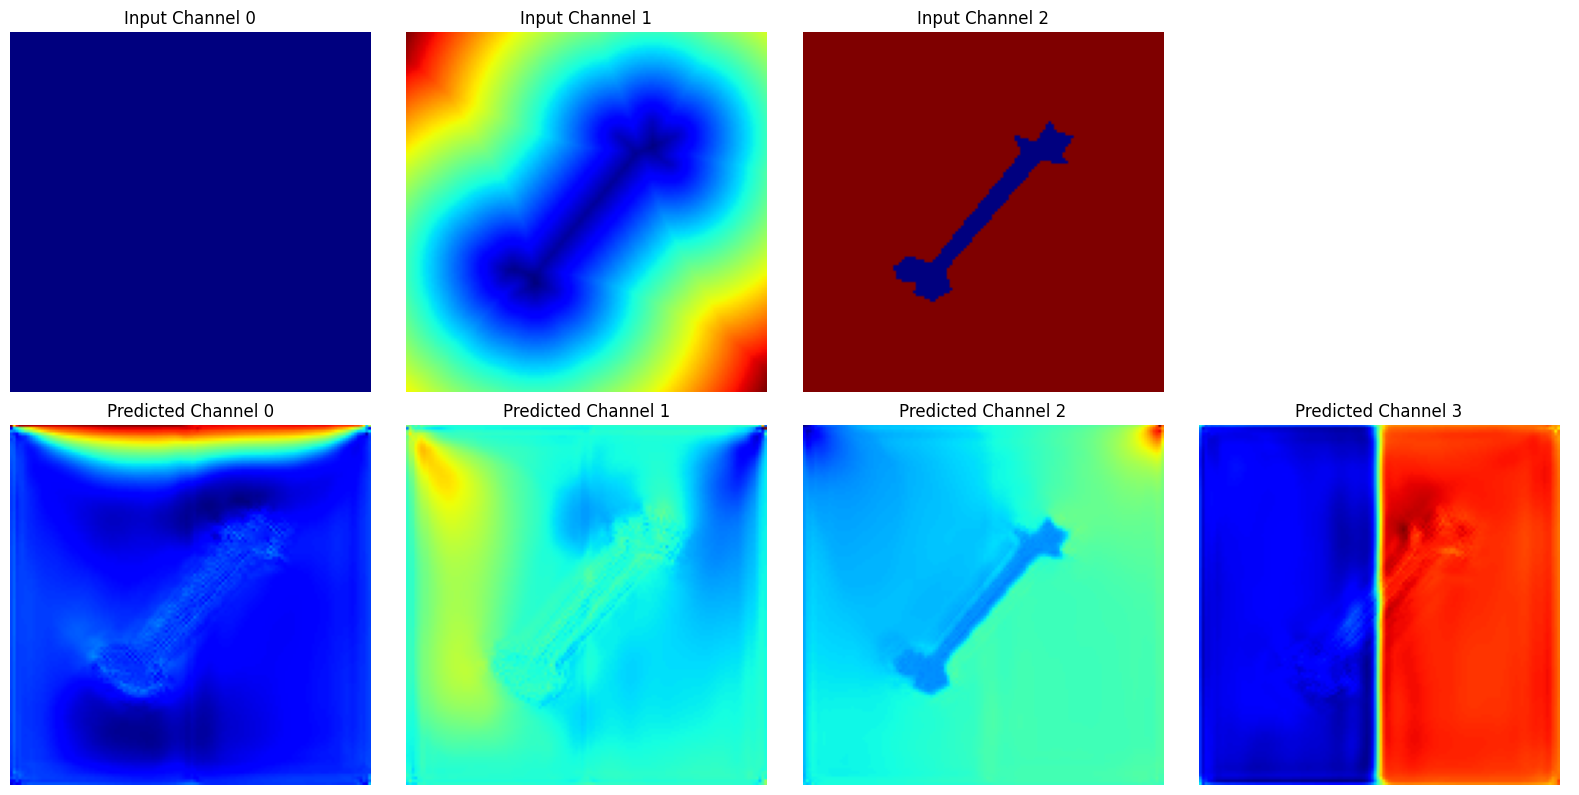

In [40]:
import torch
import matplotlib.pyplot as plt
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)
# ----------------------------
# Evaluation
# ----------------------------
model.eval()

sample_idx = 0   # any test sample index

# prepare sample
x_sample = torch.from_numpy(X[sample_idx:sample_idx+1]).float().to(device)
y_true = Y[sample_idx]  # numpy array

# forward pass
with torch.no_grad():
    y_pred = model(x_sample).cpu().numpy()[0]  # shape (out_dim, H, W)

# ----------------------------
# Visualization
# ----------------------------
in_channels  = X.shape[1]
out_channels = Y.shape[1]

fig, axes = plt.subplots(2, max(in_channels, out_channels), figsize=(4*max(in_channels,out_channels), 8))

# row 0 → Input channels
for i in range(in_channels):
    axes[0, i].imshow(X[sample_idx, i], origin='lower', cmap='jet')
    axes[0, i].set_title(f"Input Channel {i}", fontsize=12)
    axes[0, i].axis('off')

# row 1 → Predicted output channels
for i in range(out_channels):
    axes[1, i].imshow(y_pred[i], origin='lower', cmap='jet')
    axes[1, i].set_title(f"Predicted Channel {i}", fontsize=12)
    axes[1, i].axis('off')

# hide unused axes (if any)
for ax in axes.flat:
    if not ax.has_data():
        ax.axis('off')

plt.tight_layout()
plt.show()


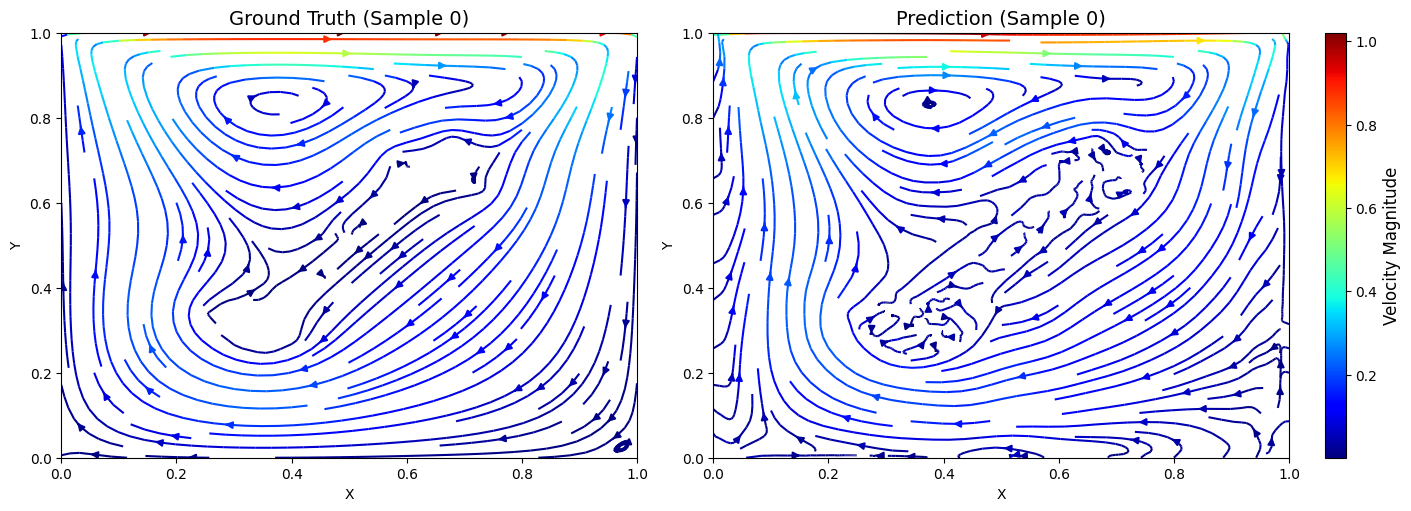

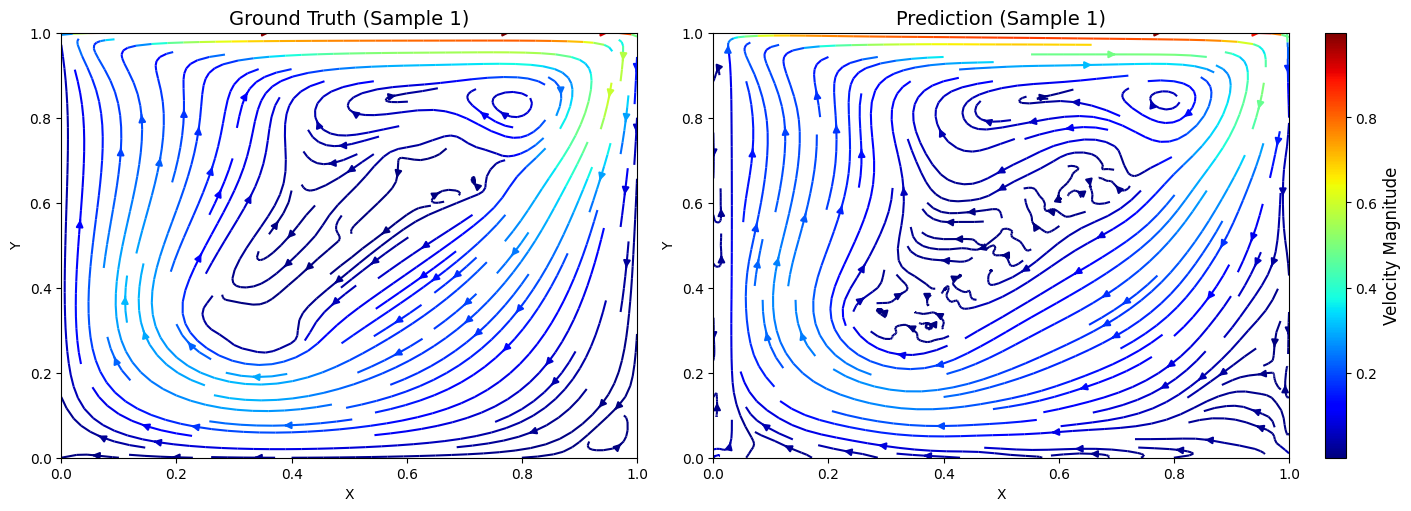

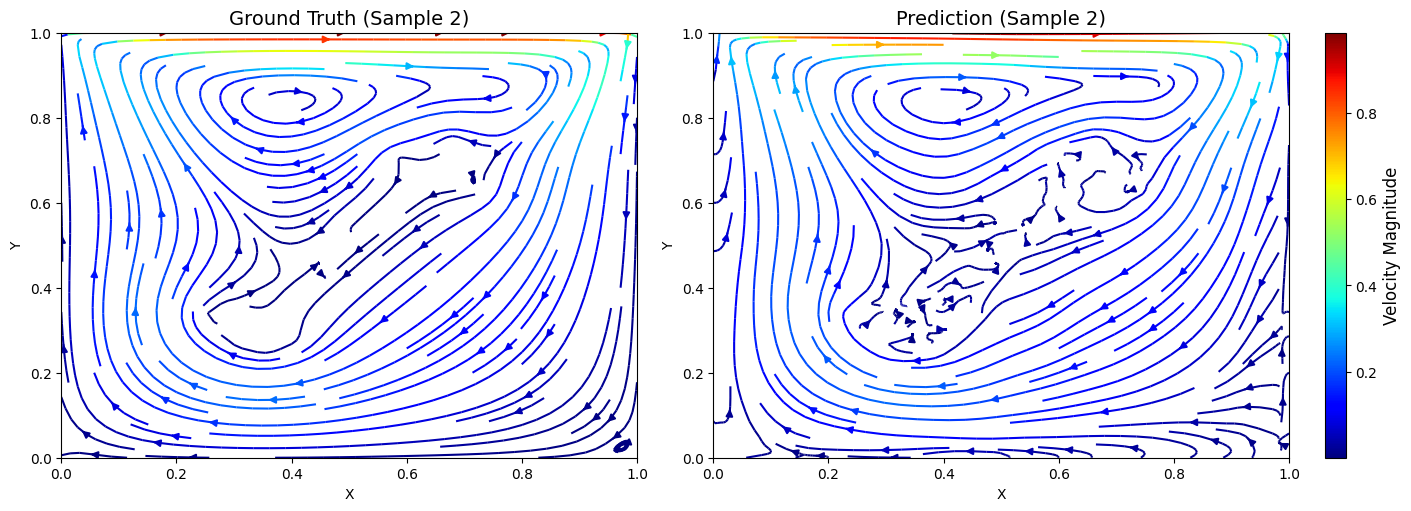

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import torch


def plot_streamlines_pair(u_true, v_true, u_pred, v_pred, sample_id, density=1.2):
    H, W = u_true.shape

    # Grid
    x = np.linspace(0, 1, W)
    y = np.linspace(0, 1, H)
    Xg, Yg = np.meshgrid(x, y)

    # ---------- Create figure ----------
    fig, axs = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

    # ---------- Common speed colormap ----------
    speed_true = np.sqrt(u_true**2 + v_true**2)
    speed_pred = np.sqrt(u_pred**2 + v_pred**2)

    vmin = min(speed_true.min(), speed_pred.min())
    vmax = max(speed_true.max(), speed_pred.max())

    # ---------- Plot GT ----------
    s1 = axs[0].streamplot(
        Xg, Yg, u_true, v_true,
        color=speed_true,
        cmap="jet",
        density=density
    )
    axs[0].set_title(f"Ground Truth (Sample {sample_id})", fontsize=14)
    axs[0].set_xlabel("X"); axs[0].set_ylabel("Y")
    axs[0].set_xlim(0, 1); axs[0].set_ylim(0, 1)

    # ---------- Plot Prediction ----------
    s2 = axs[1].streamplot(
        Xg, Yg, u_pred, v_pred,
        color=speed_pred,
        cmap="jet",
        density=density
    )
    axs[1].set_title(f"Prediction (Sample {sample_id})", fontsize=14)
    axs[1].set_xlabel("X"); axs[1].set_ylabel("Y")
    axs[1].set_xlim(0, 1); axs[1].set_ylim(0, 1)

    # ---------- Single colorbar in middle ----------
    cbar = fig.colorbar(
        s2.lines,
        ax=axs,
        location="right",
        fraction=0.035,
        pad=0.02
    )
    cbar.set_label("Velocity Magnitude", fontsize=12)

    plt.show()



# ---------------------------------------------------------
# Plot multiple samples (example: first 3)
# ---------------------------------------------------------
num_samples = 3

for idx in range(num_samples):

    # Ground truth
    u_true = Y[idx, 0]
    v_true = Y[idx, 1]

    # Prediction
    x_sample = torch.from_numpy(X[idx:idx+1]).float().to(device)
    with torch.no_grad():
        pred = model(x_sample).cpu().numpy()[0]

    u_pred = pred[0]
    v_pred = pred[1]

    # Plot comparison
    plot_streamlines_pair(u_true, v_true, u_pred, v_pred, idx)


## Modified Architecture

In [29]:
class CNO2d(nn.Module):
    def __init__(self, in_dim, out_dim, size, N_layers=4, N_res=4, N_res_neck=4, channel_multiplier=16, use_bn=True):
        super().__init__()
        self.N_layers = N_layers
        self.lift_dim = channel_multiplier // 2
        self.in_dim = in_dim
        self.out_dim = out_dim

        # Lift
        self.lift = CNOBlock(in_dim, self.lift_dim, size, size, use_bn=False)

        # Encoder features (channels)
        # self.encoder_features: [lift_dim, C_0, C_1, ..., C_{N_layers-1}] where C_k = 2^k * channel_multiplier
        self.encoder_features = [self.lift_dim] + [2**i * channel_multiplier for i in range(N_layers)]
        # Add the neck feature size (output of the last encoder block)
        # For N_layers=4, cm=16, this list becomes [8, 16, 32, 64, 128]
        self.encoder_features.append(2**(N_layers-1) * channel_multiplier * 2) # This is effectively encoder_features[N_layers] which was missing the last item

        # Encoder sizes (spatial dimensions)
        # For size=128, N_layers=4, this list becomes [128, 64, 32, 16, 8]
        self.encoder_sizes = [size // 2**i for i in range(N_layers + 1)]

        # Encoder
        self.encoder = nn.ModuleList([CNOBlock(self.encoder_features[i], self.encoder_features[i+1],
                                               self.encoder_sizes[i], self.encoder_sizes[i+1], use_bn)
                                      for i in range(N_layers)])

        # ResNets in encoder path
        self.res_nets = nn.ModuleList([ResNet(self.encoder_features[i], self.encoder_sizes[i], N_res, use_bn)
                                       for i in range(N_layers)])
        self.res_net_neck = ResNet(self.encoder_features[N_layers], self.encoder_sizes[N_layers], N_res_neck, use_bn)


        # --- Decoder specific channel and size definitions ---
        decoder_input_channels = []
        decoder_output_channels = []
        decoder_spatial_sizes_in = []
        decoder_spatial_sizes_out = []

        # First decoder block (i=0) takes input from the neck
        # Input channels: output of res_net_neck = self.encoder_features[N_layers] (e.g. 128)
        # Output channels: should match the skip connection it will be combined with in the next stage
        #                  which is self.encoder_features[N_layers - 1] (e.g. 64)
        decoder_input_channels.append(self.encoder_features[N_layers])
        decoder_output_channels.append(self.encoder_features[N_layers - 1])
        decoder_spatial_sizes_in.append(self.encoder_sizes[N_layers]) # e.g., 8
        decoder_spatial_sizes_out.append(self.encoder_sizes[N_layers - 1]) # e.g., 16

        # Subsequent decoder blocks (i=1 to N_layers-1)
        for i in range(1, N_layers):
            # Input channels = (output of previous decoder block) + (channels from skip connection)
            # The skip connection comes from encoder_features[N_layers - i]
            # The output of the previous decoder block is decoder_output_channels[i-1]
            input_ch = decoder_output_channels[i-1] + self.encoder_features[N_layers - i]
            decoder_input_channels.append(input_ch)
            decoder_output_channels.append(self.encoder_features[N_layers - i - 1])

            decoder_spatial_sizes_in.append(self.encoder_sizes[N_layers - i]) # e.g., 16, 32, 64
            decoder_spatial_sizes_out.append(self.encoder_sizes[N_layers - i - 1]) # e.g., 32, 64, 128

        self.decoder = nn.ModuleList([CNOBlock(decoder_input_channels[i], decoder_output_channels[i],
                                               decoder_spatial_sizes_in[i], decoder_spatial_sizes_out[i], use_bn)
                                      for i in range(N_layers)])

        # Projection layer
        # Input to project is x (output of last decoder block) concatenated with skip[0]
        # Channels: decoder_output_channels[-1] + self.encoder_features[0]
        self.project = nn.Conv2d(decoder_output_channels[-1] + self.encoder_features[0], out_dim, 3, padding=1)

    def forward(self, x):
        x = self.lift(x)
        skip = []
        # Encoder
        for i in range(self.N_layers):
            y = self.res_nets[i](x)
            skip.append(y)
            x = self.encoder[i](x)
        x = self.res_net_neck(x)

        # Decoder
        for i in range(self.N_layers):
            if i > 0:
                # x is output of decoder[i-1]
                # skip[self.N_layers - i] retrieves the correct skip connection
                # For N_layers=4: i=1 -> skip[3], i=2 -> skip[2], i=3 -> skip[1]
                x = torch.cat((x, skip[self.N_layers - i]), dim=1)
            x = self.decoder[i](x)

        # Final projection
        # x is output of last decoder block
        # skip[0] is the first skip connection (from lift_dim)
        x = torch.cat((x, skip[0]), dim=1)
        x = self.project(x)
        return x


In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNO2d(in_dim=3, out_dim=4, size=128).to(device)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-8)
criterion = nn.L1Loss()
epochs = 20

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
    train_loss /= len(train_dataset)

    # Test evaluation
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            test_loss += criterion(y_pred, y_batch).item() * x_batch.size(0)
        test_loss /= len(test_dataset)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")


Epoch 1/20, Train Loss: 1.489676, Test Loss: 0.527778
Epoch 2/20, Train Loss: 0.397336, Test Loss: 0.230103
Epoch 3/20, Train Loss: 0.277583, Test Loss: 0.151260
Epoch 4/20, Train Loss: 0.173121, Test Loss: 0.129866
Epoch 5/20, Train Loss: 0.137505, Test Loss: 0.103302
Epoch 6/20, Train Loss: 0.126998, Test Loss: 0.075538
Epoch 7/20, Train Loss: 0.101728, Test Loss: 0.068530
Epoch 8/20, Train Loss: 0.084314, Test Loss: 0.060718
Epoch 9/20, Train Loss: 0.076182, Test Loss: 0.057656
Epoch 10/20, Train Loss: 0.068527, Test Loss: 0.054946
Epoch 11/20, Train Loss: 0.062481, Test Loss: 0.052331
Epoch 12/20, Train Loss: 0.060233, Test Loss: 0.048268
Epoch 13/20, Train Loss: 0.058277, Test Loss: 0.043738
Epoch 14/20, Train Loss: 0.056401, Test Loss: 0.041792
Epoch 15/20, Train Loss: 0.052007, Test Loss: 0.041886
Epoch 16/20, Train Loss: 0.051798, Test Loss: 0.041162
Epoch 17/20, Train Loss: 0.049155, Test Loss: 0.040591
Epoch 18/20, Train Loss: 0.047912, Test Loss: 0.049579
Epoch 19/20, Train 

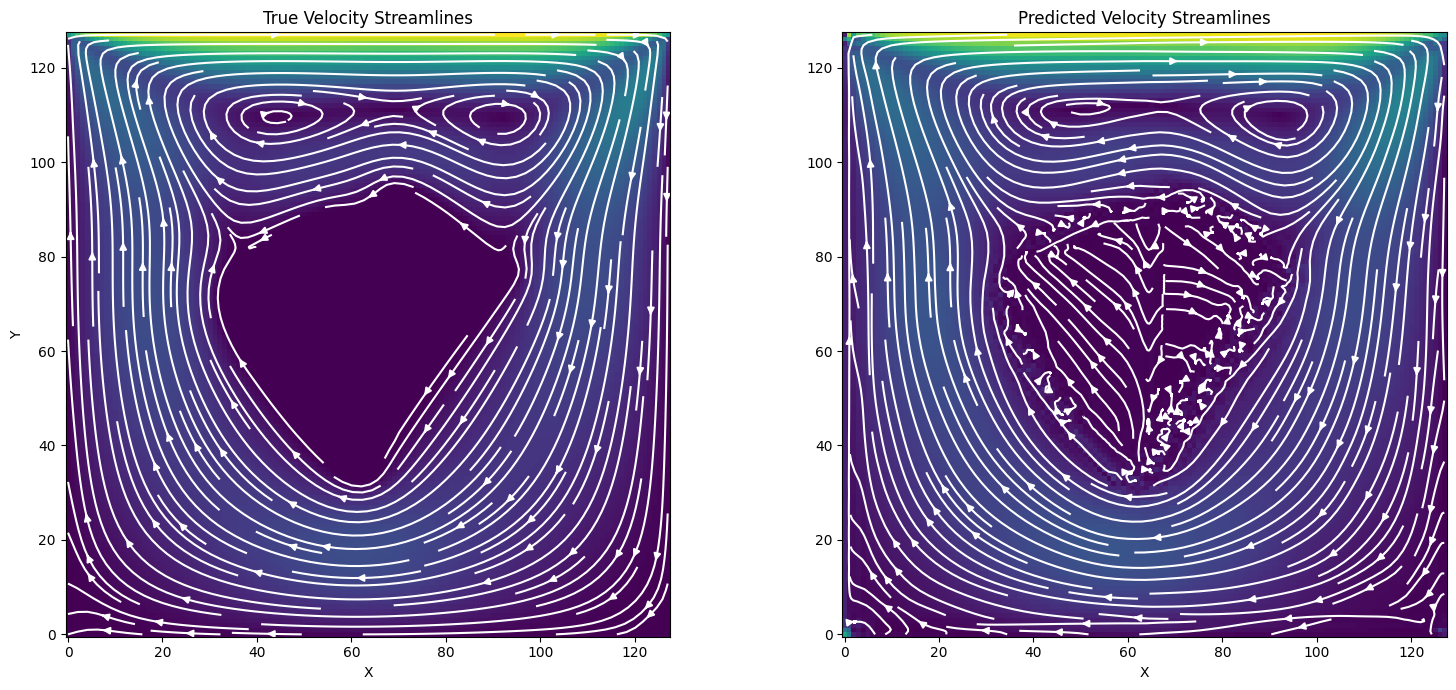

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# ----------------------------
# Select a test sample
# ----------------------------
sample_idx = 0

x_sample, y_true = test_dataset[sample_idx]
x_sample = x_sample.unsqueeze(0).to(device)

# Model prediction
model.eval()
with torch.no_grad():
    y_pred = model(x_sample)[0]   # shape: (C, H, W)

# ----------------------------
# Convert tensors -> numpy
# ----------------------------
y_true = y_true.cpu().numpy()
y_pred = y_pred.cpu().numpy()

true_u = y_true[0]
true_v = y_true[1]

pred_u = y_pred[0]
pred_v = y_pred[1]

# ----------------------------
# Create meshgrid
# ----------------------------
H, W = true_u.shape
X_grid, Y_grid = np.meshgrid(np.arange(W), np.arange(H))

# ----------------------------
# Plot side-by-side streamlines
# ----------------------------
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

# --- True ---
axs[0].imshow(np.sqrt(true_u**2 + true_v**2), cmap='viridis', origin='lower')
axs[0].streamplot(X_grid, Y_grid, true_u, true_v, color='white', density=2)
axs[0].set_title("True Velocity Streamlines")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")

# --- Pred ---
axs[1].imshow(np.sqrt(pred_u**2 + pred_v**2), cmap='viridis', origin='lower')
axs[1].streamplot(X_grid, Y_grid, pred_u, pred_v, color='white', density=2)
axs[1].set_title("Predicted Velocity Streamlines")
axs[1].set_xlabel("X")

plt.tight_layout()
plt.show()


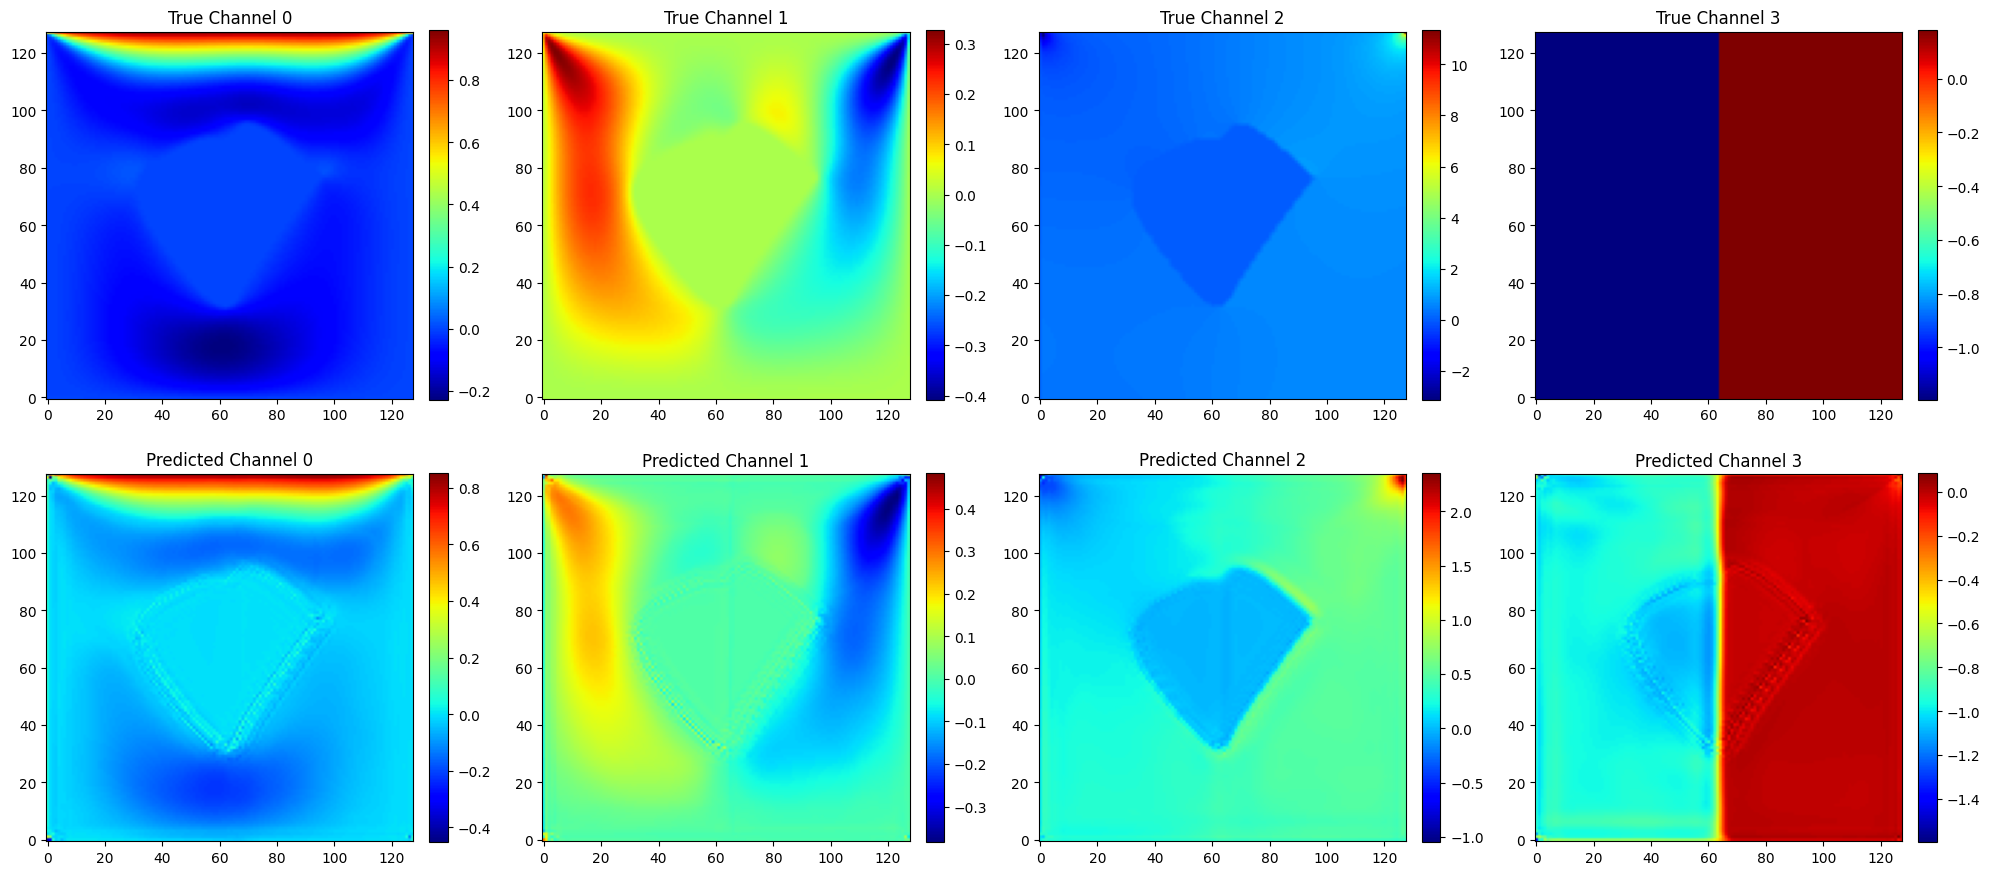

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# ----------------------------
# Select a test sample
# ----------------------------
sample_idx = 0

x_sample, y_true = test_dataset[sample_idx]
x_sample = x_sample.unsqueeze(0).to(device)

# Model prediction
model.eval()
with torch.no_grad():
    y_pred = model(x_sample)[0]   # shape: (C, H, W)

# Convert to numpy
y_true = y_true.cpu().numpy()
y_pred = y_pred.cpu().numpy()

num_channels = y_true.shape[0]   # Example: 4 (u, v, p, w)
H, W = y_true.shape[1], y_true.shape[2]

# ----------------------------
# Plot Heatmaps
# ----------------------------
fig, axs = plt.subplots(2, num_channels, figsize=(5*num_channels, 9))

for c in range(num_channels):
    # --- True heatmap ---
    im1 = axs[0, c].imshow(y_true[c], cmap='jet', origin='lower')
    axs[0, c].set_title(f"True Channel {c}")
    plt.colorbar(im1, ax=axs[0, c], fraction=0.046, pad=0.04)

    # --- Pred heatmap ---
    im2 = axs[1, c].imshow(y_pred[c], cmap='jet', origin='lower')
    axs[1, c].set_title(f"Predicted Channel {c}")
    plt.colorbar(im2, ax=axs[1, c], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
